<a href="https://colab.research.google.com/github/enakai00/JAX_workshop/blob/main/3_Flax_Transformer_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Preparation

In [ ]:
%%bash
pip install -q git+https://github.com/huggingface/transformers.git datasets
pip install -q flax==0.6.1 jax==0.3.25 optax==0.1.3 jedi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 13.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 96.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.6/185.6 KB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.1/145.1 KB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.0/239.0 KB 25.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.5/84.5 KB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from functools import partial

import jax, optax
from jax import random, numpy as jnp
from flax import linen as nn
from flax.training import train_state
from flax.training import train_state, checkpoints

plt.rcParams.update({'font.size': 12})

## Prepare dataset

In [ ]:
from datasets import load_dataset
emotions = load_dataset('emotion')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/split/1.0.0/cca5efe2dfeb58c1d098e0f9eeb200e9927d889b5a03c67097275dfb5fe463bd. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
emotions['train']['text'][:3]

['i didnt feel humiliated',
 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake',
 'im grabbing a minute to post i feel greedy wrong']

In [ ]:
from transformers import AutoTokenizer, AutoConfig
model_ckpt = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
vocab_size = AutoConfig.from_pretrained(model_ckpt).vocab_size

vocab_size

30522

In [ ]:
max([len(text.split(' '))
     for text in emotions['train']['text'] + emotions['validation']['text']])

66

In [ ]:
text_length = 128

# Training set
train_set = tokenizer(emotions['train']['text'], max_length=text_length,
                      padding='max_length', truncation=True)
train_text = np.array(train_set['input_ids'])
train_mask = np.array(train_set['attention_mask'])
train_label = np.eye(6)[emotions['train']['label']]

# Test set
test_set = tokenizer(emotions['validation']['text'], max_length=text_length,
                     padding='max_length', truncation=True)
test_text = np.array(test_set['input_ids'])
test_mask = np.array(test_set['attention_mask'])
test_label = np.eye(6)[emotions['validation']['label']]

emotion_labels = emotions['train'].features['label'].names

In [ ]:
train_text[0]

array([  101,  1045,  2134,  2102,  2514, 26608,   102,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0]

In [ ]:
train_mask[0]

array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
train_label[0]

array([1., 0., 0., 0., 0., 0.])

In [ ]:
emotion_labels

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

## Embedding layer

In [ ]:
class Embeddings(nn.Module):
    embed_dim: int
    text_length: int = text_length
    vocab_size: int = vocab_size

    @nn.compact
    def __call__(self, input_ids, eval):
        token_embeddings = nn.Embed(
            self.vocab_size, self.embed_dim)(input_ids)
        position_ids = jnp.arange(self.text_length)
        position_embeddings = nn.Embed(
            self.text_length, self.embed_dim)(position_ids)
        embeddings = token_embeddings + position_embeddings # broadcast
        embeddings = nn.LayerNorm(epsilon=1e-12)(embeddings)
        embeddings = nn.Dropout(0.5, deterministic=eval)(embeddings)
        return embeddings

In [ ]:
variables = Embeddings(embed_dim=512).init(random.PRNGKey(0), train_text[:1], eval=True)
jax.tree_util.tree_map(lambda x: x.shape, variables['params'])

FrozenDict({
    Embed_0: {
        embedding: (30522, 512),
    },
    Embed_1: {
        embedding: (128, 512),
    },
    LayerNorm_0: {
        bias: (512,),
        scale: (512,),
    },
})

In [ ]:
input_text = train_text[:3]
output = Embeddings(embed_dim=512).apply(variables, input_text, eval=True)
input_text.shape, output.shape

((3, 128), (3, 128, 512))

## Multi-head Attention

In [ ]:
class AttentionHead(nn.Module):
    head_dim: int

    def scaled_dot_product_attention(self, q, k, v, mask):
        scores = jnp.matmul(q, jnp.transpose(k, (0, 2, 1)))
        if mask is not None:
            mask = jnp.tile(mask, mask.shape[-1]).reshape(
                    mask.shape[0], -1, mask.shape[-1])
            scores = jnp.where(mask==0, -jnp.inf, scores)
        w = nn.softmax(scores / jnp.sqrt(self.head_dim))
        return jnp.matmul(w, v)

    @nn.compact
    def __call__(self, hidden_state, attention_mask):
        q = nn.Dense(features=self.head_dim)(hidden_state)
        k = nn.Dense(features=self.head_dim)(hidden_state)
        v = nn.Dense(features=self.head_dim)(hidden_state)
        output = self.scaled_dot_product_attention(q, k, v, attention_mask)
        return output

In [ ]:
class MultiHeadAttention(nn.Module):
    num_heads: int
    embed_dim: int

    def setup(self):
        head_dim=self.embed_dim // self.num_heads
        self.attention_heads = [AttentionHead(head_dim=head_dim)
                                for _ in jnp.arange(self.num_heads)]

    @nn.compact
    def __call__(self, hidden_state, attention_mask):
        attention_outputs = [head(hidden_state, attention_mask)
                             for head in self.attention_heads]
        x = jnp.concatenate(attention_outputs, axis=-1)
        x = nn.Dense(features=self.embed_dim)(x)
        return x

## Transformer Encoder Block

In [ ]:
class FeedForward(nn.Module):
    embed_dim: int
    intermediate_size: int = 2048

    @nn.compact
    def __call__(self, x, eval):
        x = nn.Dense(features=self.intermediate_size)(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.embed_dim)(x)
        x = nn.Dropout(0.1, deterministic=eval)(x)
        return x

In [ ]:
class TransformerEncoderBlock(nn.Module):
    num_heads: int
    embed_dim: int

    def setup(self):
        self.attention = MultiHeadAttention(
            num_heads=self.num_heads, embed_dim=self.embed_dim)
        self.feed_forward = FeedForward(embed_dim=self.embed_dim)

    @nn.compact
    def __call__(self, x, attention_mask, eval):
        x = x + self.attention(x, attention_mask) # Skip connection
        x = nn.LayerNorm()(x)
        x = x + self.feed_forward(x, eval) # Skip connection
        x = nn.LayerNorm()(x)
        return x

## Combine them all to define Transformer Encoder

In [ ]:
class TransformerEncoder(nn.Module):
    num_heads: int
    embed_dim: int
    num_hidden_layers: int

    def setup(self):
        self.embeddings = Embeddings(self.embed_dim)
        self.layers = [TransformerEncoderBlock(num_heads=self.num_heads,
                                               embed_dim=self.embed_dim)
                       for _ in range(self.num_hidden_layers)]

    def __call__(self, input_ids, attention_mask, eval):
        x = self.embeddings(input_ids, eval)
        for layer in self.layers:
            x = layer(x, attention_mask, eval=eval)
        return x

## Add Classification Head

In [ ]:
class TransformerForSequenceClassification(nn.Module):
    num_labels: int
    num_heads: int = 12
    embed_dim: int = 768
    num_hidden_layers: int = 3

    def setup(self):
        self.transformer_encoder = TransformerEncoder(
            self.num_heads, self.embed_dim, self.num_hidden_layers)

    @nn.compact
    def __call__(self, input_ids, attention_mask=None, eval=True):
        x = self.transformer_encoder(input_ids, attention_mask, eval)[:, 0, :] # select [CLS] token
        x = nn.Dropout(0.1, deterministic=eval)(x)
        logits = nn.Dense(features=self.num_labels)(x)
        return logits

## Define functions for model training

In [ ]:
@partial(jax.jit, static_argnames=['eval'])
def loss_fn(params, state, inputs, masks, labels, dropout_rng, eval):
    logits = state.apply_fn(
        {'params': params}, inputs, masks, eval=eval,
        rngs={'dropout': dropout_rng})
    loss = optax.softmax_cross_entropy(logits, labels).mean()
    acc = jnp.mean(jnp.argmax(logits, -1) == jnp.argmax(labels, -1))
    return loss, acc

In [ ]:
@partial(jax.jit, static_argnames=['eval'])
def train_step(state, inputs, masks, labels, eval):
    if not eval:
        new_dropout_rng, dropout_rng = random.split(state.dropout_rng)
        (loss, acc), grads = jax.value_and_grad(loss_fn, has_aux=True)(
            state.params, state, inputs, masks, labels, dropout_rng, eval)
        new_state = state.apply_gradients(
            grads=grads, dropout_rng=new_dropout_rng)
    else:
        loss, acc = loss_fn(
            state.params, state, inputs, masks, labels, random.PRNGKey(0), eval)
        new_state = state

    return new_state, loss, acc

In [ ]:
def train_epoch(state, input_batched, mask_batched, label_batched, eval):
    loss_history, acc_history = [], []
    for inputs, masks, labels in zip(input_batched, mask_batched, label_batched):
        new_state, loss, acc = train_step(state, inputs, masks, labels, eval)
        if not eval:
            state = new_state
        loss_history.append(jax.device_get(loss).tolist())
        acc_history.append(jax.device_get(acc).tolist())
    return state, np.mean(loss_history), np.mean(acc_history)

In [ ]:
def create_batches(data, batch_size):
    num_batches, mod = divmod(len(data), batch_size)
    data_batched = np.split(data[:num_batches * batch_size], num_batches)
    if mod: # Last batch is smaller than batch_size
        data_batched.append(data[num_batches * batch_size:])
    data_batched = [jnp.asarray(x) for x in data_batched]
    return data_batched

In [ ]:
def fit(state, ckpt_dir, prefix,
        train_text, train_mask, train_label,
        test_text, test_mask, test_label,
        epochs, batch_size):

    state = checkpoints.restore_checkpoint(
        ckpt_dir=ckpt_dir, prefix=prefix, target=state)

    train_text_batched = create_batches(train_text, batch_size)
    train_mask_batched = create_batches(train_mask, batch_size)
    train_label_batched = create_batches(train_label, batch_size)
    test_text_batched = create_batches(test_text, batch_size)
    test_mask_batched = create_batches(test_mask, batch_size)
    test_label_batched = create_batches(test_label, batch_size)

    loss_history_train, acc_history_train = [], []
    loss_history_test, acc_history_test = [], []

    for epoch in range(state.epoch + 1, state.epoch + 1 + epochs):
        # Training
        state, loss_train, acc_train = train_epoch(
            state, train_text_batched, train_mask_batched, train_label_batched, eval=False)
        loss_history_train.append(loss_train)
        acc_history_train.append(acc_train)

        # Evaluation
        _ , loss_test, acc_test = train_epoch(
            state, test_text_batched, test_mask_batched, test_label_batched, eval=True)
        loss_history_test.append(loss_test)
        acc_history_test.append(acc_test)

        print ('Epoch: {}, Loss: {:.4f}, Accuracy: {:.4f} / '.format(
            epoch, loss_train, acc_train), end='', flush=True)
        print ('Loss(Test): {:.4f}, Accuracy(Test): {:.4f}'.format(
            loss_test, acc_test), flush=True)

        state = state.replace(epoch=state.epoch+1)
        checkpoints.save_checkpoint(
            ckpt_dir=ckpt_dir, prefix=prefix,
            target=state, step=state.epoch, overwrite=True, keep=5)

    history = {'loss_train': loss_history_train,
               'acc_train': acc_history_train,
               'loss_test': loss_history_test,
               'acc_test': acc_history_test}

    return state, history

## Model Training

In [ ]:
class TrainState(train_state.TrainState):
    epoch: int
    dropout_rng: type(random.PRNGKey(0))

model = TransformerForSequenceClassification(
    num_labels=6, num_heads=8, embed_dim=512, num_hidden_layers=2)

key, key1, key2 = random.split(random.PRNGKey(0), 3)
variables = model.init(key1, train_text[:1])
state = TrainState.create(
    apply_fn=model.apply,
    params=variables['params'],
    tx=optax.adam(learning_rate=0.00005),
    dropout_rng=key2,
    epoch=0)

In [ ]:
checkpoints.save_checkpoint(
    ckpt_dir='./checkpoints/', prefix='TextClassification_checkpoint_',
    target=state, step=state.epoch, overwrite=True)

'checkpoints/TextClassification_checkpoint_0'

In [ ]:
%%time
ckpt_dir = './checkpoints/'
prefix = 'TextClassification_checkpoint_'
state, history = fit(state, ckpt_dir, prefix,
        train_text, train_mask, train_label,
        test_text, test_mask, test_label,
        epochs=16, batch_size=32)

Epoch: 1, Loss: 1.6664, Accuracy: 0.3089 / Loss(Test): 1.5604, Accuracy(Test): 0.3814
Epoch: 2, Loss: 1.5732, Accuracy: 0.3621 / Loss(Test): 1.4319, Accuracy(Test): 0.4653
Epoch: 3, Loss: 1.3712, Accuracy: 0.4824 / Loss(Test): 0.8860, Accuracy(Test): 0.6870
Epoch: 4, Loss: 0.9353, Accuracy: 0.6611 / Loss(Test): 0.4823, Accuracy(Test): 0.8433
Epoch: 5, Loss: 0.5925, Accuracy: 0.7938 / Loss(Test): 0.3562, Accuracy(Test): 0.8760
Epoch: 6, Loss: 0.4374, Accuracy: 0.8471 / Loss(Test): 0.3241, Accuracy(Test): 0.8884
Epoch: 7, Loss: 0.3606, Accuracy: 0.8709 / Loss(Test): 0.2955, Accuracy(Test): 0.8938
Epoch: 8, Loss: 0.3204, Accuracy: 0.8810 / Loss(Test): 0.2717, Accuracy(Test): 0.8948
Epoch: 9, Loss: 0.2834, Accuracy: 0.8922 / Loss(Test): 0.2661, Accuracy(Test): 0.8963
Epoch: 10, Loss: 0.2607, Accuracy: 0.8988 / Loss(Test): 0.2571, Accuracy(Test): 0.9053
Epoch: 11, Loss: 0.2400, Accuracy: 0.9058 / Loss(Test): 0.2572, Accuracy(Test): 0.9023
Epoch: 12, Loss: 0.2180, Accuracy: 0.9126 / Loss(Tes

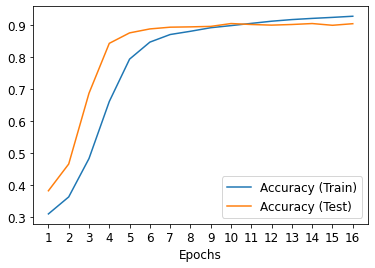

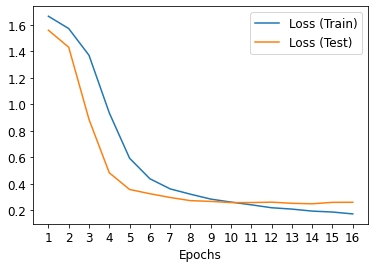

In [ ]:
df = DataFrame({'Accuracy (Train)': history['acc_train'],
                'Accuracy (Test)': history['acc_test']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(6, 4))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

df = DataFrame({'Loss (Train)': history['loss_train'],
                'Loss (Test)': history['loss_test']})
df.index.name = 'Epochs'
ax = df.plot(figsize=(6, 4))
ax.set_xticks(df.index)
_ = ax.set_xticklabels(df.index+1)

## Model Evaluation

In [ ]:
predictions = jax.device_get(
    state.apply_fn({'params': state.params}, test_text, test_mask))

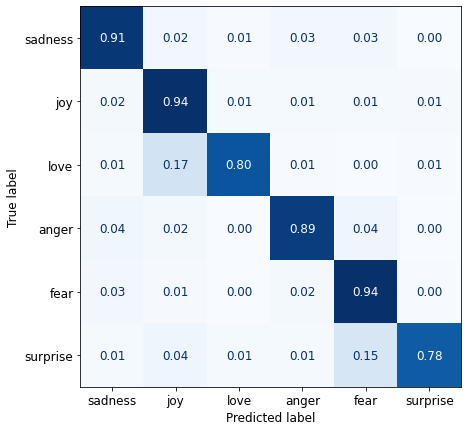

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(
    y_pred = np.argmax(predictions, axis=1),
    y_true = np.argmax(test_label, axis=1),
    normalize='true')
fig, ax = plt.subplots(figsize=(7, 7))
disp = ConfusionMatrixDisplay(cm, display_labels=emotions['validation'].features['label'].names)
_ = disp.plot(cmap='Blues', values_format='.2f', colorbar=False, ax=ax)

In [ ]:
input_text = ["I am so happy to be here with you.",
              "I am so heartbroken that I don't know what to do with myself."]

tokenized_text = tokenizer(input_text, max_length=len(train_text[0]),
                           padding='max_length', truncation=True)
input_ids = np.array(tokenized_text['input_ids'])
mask = np.array(tokenized_text['attention_mask'])

predictions = jax.device_get(
    state.apply_fn({'params': state.params}, input_ids, mask))

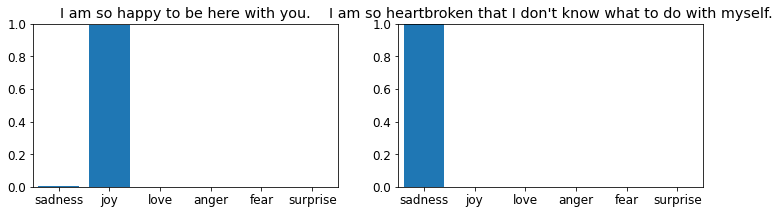

In [ ]:
fig = plt.figure(figsize=(12, 3))
for c, pred in enumerate(predictions):
    probs = np.exp(pred)/sum(np.exp(pred))
    subplot = fig.add_subplot(1, 2, c+1)
    subplot.set_xticks(range(6))
    subplot.set_xlim([-0.5, 5.5])
    subplot.set_ylim([0, 1])
    subplot.set_xticklabels(emotion_labels)
    subplot.set_title(input_text[c])
    _ = subplot.bar(range(6), probs, align='center')